In [76]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2


from datetime import datetime, date, time, timedelta
import numpy as np  ## Import the NumPy package
import matplotlib.pyplot as plt  ## import fundamental plotting library in Python
import seaborn as sns  ## Advanced plotting functionality with seaborn
sns.set(style="whitegrid") # can set style depending on how you'd like it to look

import os

### Load Database

El siguiente link muestra como cargar la base de datos "kavak_db_v1_0_1.sql" en pgadmin:
https://www.youtube.com/watch?v=C30q5i1e9KE

In [77]:
## Conect postgres to python
conn = psycopg2.connect(database="kavak", user="postgres", password="2FaceCoin!")  #load database
cursor1=conn.cursor()

In [78]:
# Save Query into a dataframe

car_description = pd.read_sql_query("select a.*, b.name location_name from car_description a LEFT JOIN showroom b on a.sold_location_id=b.showroom_id", conn)  
car_pageviews = pd.read_sql_query("select * from car_pageviews", conn)
showroom_visits = pd.read_sql_query("select a.*, b.name location_name from showroom_visits a LEFT JOIN showroom b on a.showroom_id=b.showroom_id", conn)  
showroom = pd.read_sql_query("select * from showroom", conn)


In [ ]:
#car_description = pd.read_sql_query(
#    '''SELECT e.*, f.views FROM
#            (SELECT c.*, d.name brand_name FROM
#                (SELECT a.*, b.name location_name 
#                 FROM car_description a LEFT JOIN showroom b 
#                 ON a.sold_location_id=b.showroom_id) c
#            LEFT JOIN brands d ON c.brand_id=d.brand_id) e
#         LEFT JOIN 
#             (SELECT *,right(gmb_pagepath,(char_length(gmb_pagepath)-(position('autos-' in gmb_pagepath)+5))) stock_id 
#              FROM car_pageviews) f
#         ON e.stock_id=f.stock_id
#    ''', conn)

In [79]:
car_description = pd.read_sql_query(
    '''SELECT c.*, d.name brand_name FROM
            (SELECT a.*, b.name location_name 
             FROM car_description a LEFT JOIN showroom b 
        ON a.sold_location_id=b.showroom_id) c
        LEFT JOIN brands d ON c.brand_id=d.brand_id
    ''', conn)

In [60]:
car_description.head(2)

,car_description_id,item,location_id,sold_location_id,stock_id,internal_id,brand_id,year,km,sku,...,buy_price,published_price,price_segment,km_segment,model_segment,maker_segment,delivered_date,inventory_days,location_name,brand_name
0,1,AUTO 16420 ENTREGADO - Hyundai Grand i10 2016 ...,7,0,16420,6689035,0,2004,34572,H19P160210,...,121497.0,142999.0,1,1,1,1,2019-12-12,20,Florencia,Hyundai
1,2,AUTO 18032 ENTREGADO - Nissan March 2016 - 275...,7,0,18032,7874212,1,2009,25445,N32P160109,...,122576.0,152999.0,1,1,1,1,2020-03-11,64,Florencia,Nissan


### Pageviews Stock_ID & Datetime Format

In [80]:
### Add stock_ID to the dataset for Pageviews table
car_pageviews['stock_id'] = car_pageviews['gmb_pagepath'].apply(lambda x: x[(x.rfind("autos-")+6):len(x)])

##Create date columns
car_pageviews['gmb_datetime'] = pd.to_datetime(car_pageviews['gmb_date'], format="%Y-%m-%d")
car_pageviews['year'] = car_pageviews['gmb_datetime'].dt.year
car_pageviews['month'] = car_pageviews['gmb_datetime'].dt.month
car_pageviews['my'] =pd.to_datetime(("01" + "/" + car_pageviews['month'].astype(str) + "/" + car_pageviews['year'].astype(str)), format="%d/%m/%Y")


### Visits Datetime Format

In [81]:
##Delete showroom equal to "FUERA DE KAVAK"
#car_description = car_description.drop(car_description[car_description['location_name']=="FUERA DE KAVAK"].index)
list_of_values = ['otro', 'NaN','Patio Tlalpan']
showroom_visits = showroom_visits.drop(showroom_visits[showroom_visits['location_name']=='otro'].index)
showroom_visits = showroom_visits.drop(showroom_visits[showroom_visits['location_name']=='NaN'].index)
showroom_visits = showroom_visits.drop(showroom_visits[showroom_visits['location_name']=='Patio Tlalpan'].index)

##Create date columns for Visits Table
showroom_visits['last_updatetime'] = pd.to_datetime(showroom_visits['last_update'], format="%Y-%m-%d")
showroom_visits['year'] = showroom_visits['last_updatetime'].dt.year
showroom_visits['month'] = showroom_visits['last_updatetime'].dt.month
showroom_visits['my'] =pd.to_datetime(("01" + "/" + showroom_visits['month'].astype(str) + "/" + showroom_visits['year'].astype(str)), format="%d/%m/%Y")

### Sales aditional columns

In [82]:
import datetime

##Delete showroom equal to "FUERA DE KAVAK"
#car_description = car_description.drop(car_description[car_description['location_name']=="FUERA DE KAVAK"].index)
list_of_values = ['otro']
car_description = car_description.drop(car_description[car_description['location_name']=='otro'].index)


## Create new columns for numeric KAVAK SEGMENTS

a=('[ 79,999 - 209,999 ]','[ 212,999 - 339,999 ]','[ 342,999 - 1054,999 ]')
a=('[ 1,050 - 36,300 ]','[ 36,649 - 64,851 ]','[ 64,965 - 110,900 ]')
a=('Low','Mid','High')

car_description['new_price_segment'] = car_description['price_segment'].map({1: "[ 79,999 - 209,999 ]", 2: "[ 212,999 - 339,999 ]", 3: "[ 342,999 - 1054,999 ]"})
car_description['new_km_segment'] = car_description['km_segment'].map({1: "[ 1,050 - 36,300 ]", 2: "[ 36,649 - 64,851 ]", 3: "[ 64,965 - 110,900 ]"})
car_description['new_model_segment'] = car_description['model_segment'].map({1: "Low", 2: "Mid", 3: "High"})


##Create date columns
car_description['sold_datetime'] = pd.to_datetime(car_description['sold_date'], format="%Y-%m-%d")
car_description['year'] = car_description['sold_datetime'].dt.year
car_description['month'] = car_description['sold_datetime'].dt.month
car_description['my'] =pd.to_datetime(("01" + "/" + car_description['month'].astype(str) + "/" + car_description['year'].astype(str)), format="%d/%m/%Y")


### Sum total pageviews per car ###

car_description['tot_pageviews']=9999

for indice_fila, fila in car_description.iterrows():
    stockid=car_description.loc[indice_fila,'stock_id']
    stockid=str(stockid)
    lastdate=car_description.loc[indice_fila,'sold_datetime']
    invdays=car_description.loc[indice_fila,'inventory_days']
    invdays=int(invdays)
    firstdate = lastdate-datetime.timedelta(days=invdays)
    #if invdays>=60:
    #    invdays=60
    #else:
    #    invdays
    newlastday = firstdate+datetime.timedelta(days=invdays)
    pv = car_pageviews[(car_pageviews['stock_id']==stockid) & (car_pageviews['gmb_datetime']<=newlastday)]
    value=pv['views'].sum()
    car_description.loc[indice_fila,'tot_pageviews']=value

    
### cars without pageviews ###
car_description['wopv']=99

for indice_fila, fila in car_description.iterrows():
    a=int(car_description.loc[indice_fila,'tot_pageviews'])
    if a>0:
        car_description.loc[indice_fila,'wopv']=1
    else:
        car_description.loc[indice_fila,'wopv']=0



## EDA GRAPHS

In [84]:
car_description.columns

Index(['car_description_id', 'item', 'location_id', 'sold_location_id',
       'stock_id', 'internal_id', 'brand_id', 'year', 'km', 'sku', 'color',
       'sold_date', 'version', 'accepted_offer_type', 'buy_price',
       'published_price', 'price_segment', 'km_segment', 'model_segment',
       'maker_segment', 'delivered_date', 'inventory_days', 'location_name',
       'brand_name', 'new_price_segment', 'new_km_segment',
       'new_model_segment', 'sold_datetime', 'month', 'my', 'tot_pageviews',
       'wopv'],
      dtype='object')

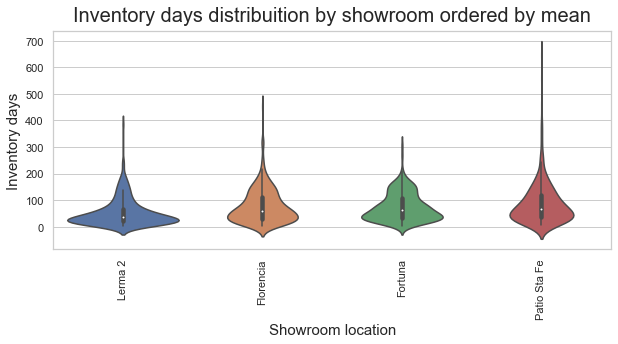

In [92]:
# Define figure size, create plot
order = car_description.groupby('location_name')['inventory_days'].median().sort_values(ascending=True).iloc[::1].index

fig, ax = plt.subplots(figsize=(10,4))
m = sns.violinplot(x="location_name",y="inventory_days",data=car_description,orient='vertical',showfliers=False, order=order)

# Format plot
plt.title('Inventory days distribuition by showroom ordered by mean', fontsize=20, verticalalignment='bottom')
plt.xticks(rotation=90);
plt.xlabel('Showroom location', fontsize = 15)
plt.ylabel('Inventory days', fontsize = 15);

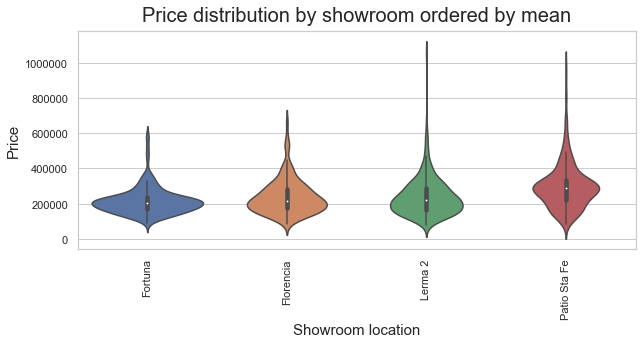

In [91]:
# Define figure size, create plot
order = car_description.groupby('location_name')['published_price'].median().sort_values(ascending=True).iloc[::1].index

fig, ax = plt.subplots(figsize=(10,4))
m = sns.violinplot(x="location_name",y="published_price",data=car_description,orient='vertical',showfliers=False, order=order)

# Format plot
plt.title('Price distribution by showroom ordered by mean', fontsize=20, verticalalignment='bottom')
plt.xticks(rotation=90);
plt.xlabel('Showroom location', fontsize = 15)
plt.ylabel('Price', fontsize = 15);

Text(0.5, 0, 'Showroom location')

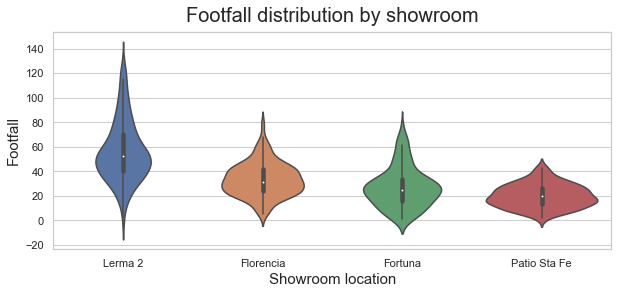

In [89]:
order = showroom_visits.groupby('location_name')['visits'].mean().sort_values(ascending=True).iloc[::1].index
fig, ax = plt.subplots(figsize=(10,4))
#m = sns.violinplot(x="location_name",y="visits",data=showroom_visits,order = ['WH - LERMA', 'PLAZA FORTUNA', 'FLORENCIA', 'SANTA FE'] )
m = sns.violinplot(x="location_name",y="visits",data=showroom_visits)
m.set_title('Footfall distribution by showroom' , fontsize=20, verticalalignment='bottom')
m.set_ylabel('Footfall' , fontsize = 15)
m.set_xlabel('Showroom location' , fontsize = 15)

Text(0.5, 0, 'Showroom location')

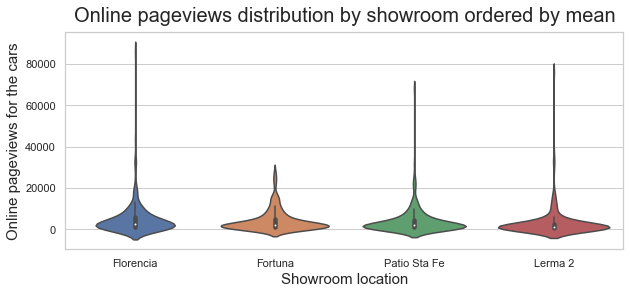

In [94]:
order = car_description.groupby('location_name')['tot_pageviews'].mean().sort_values(ascending=True).iloc[::1].index
fig, ax = plt.subplots(figsize=(10,4))
#m = sns.violinplot(x="location_name",y="visits",data=showroom_visits,order = ['WH - LERMA', 'PLAZA FORTUNA', 'FLORENCIA', 'SANTA FE'] )
m = sns.violinplot(x="location_name",y="tot_pageviews",data=car_description)
m.set_title('Online pageviews distribution by showroom ordered by mean' , fontsize=20, verticalalignment='bottom')
m.set_ylabel('Online pageviews for the cars' , fontsize = 15)
m.set_xlabel('Showroom location' , fontsize = 15)

Text(0.5, 0, 'Price')

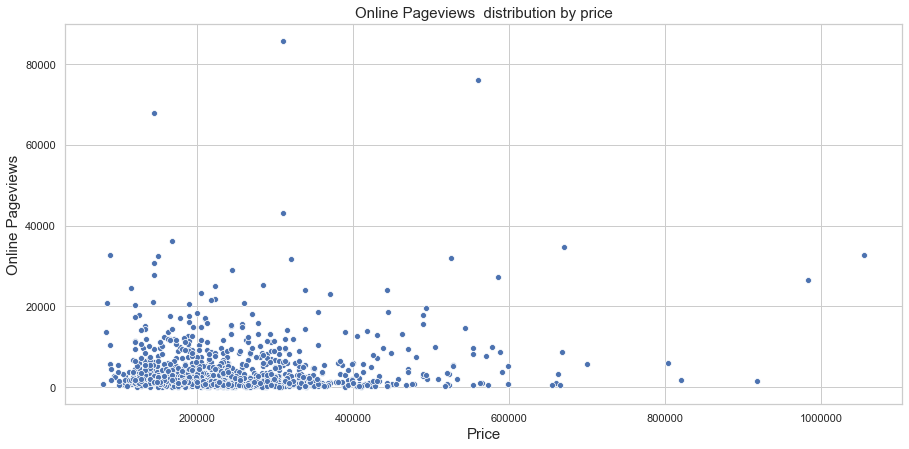

In [66]:
order = car_description.groupby('published_price')['tot_pageviews'].mean().sort_values(ascending=True).iloc[::1].index
fig, ax = plt.subplots(figsize=(15,7))
m = sns.scatterplot(x="published_price",y="tot_pageviews", data=car_description)
m.set_title('Online Pageviews  distribution by price', fontsize = 15)
m.set_ylabel('Online Pageviews', fontsize = 15)
m.set_xlabel('Price', fontsize = 15)
#[SS['LUGAR.DE.VENTA'] == "SANTA FE"]

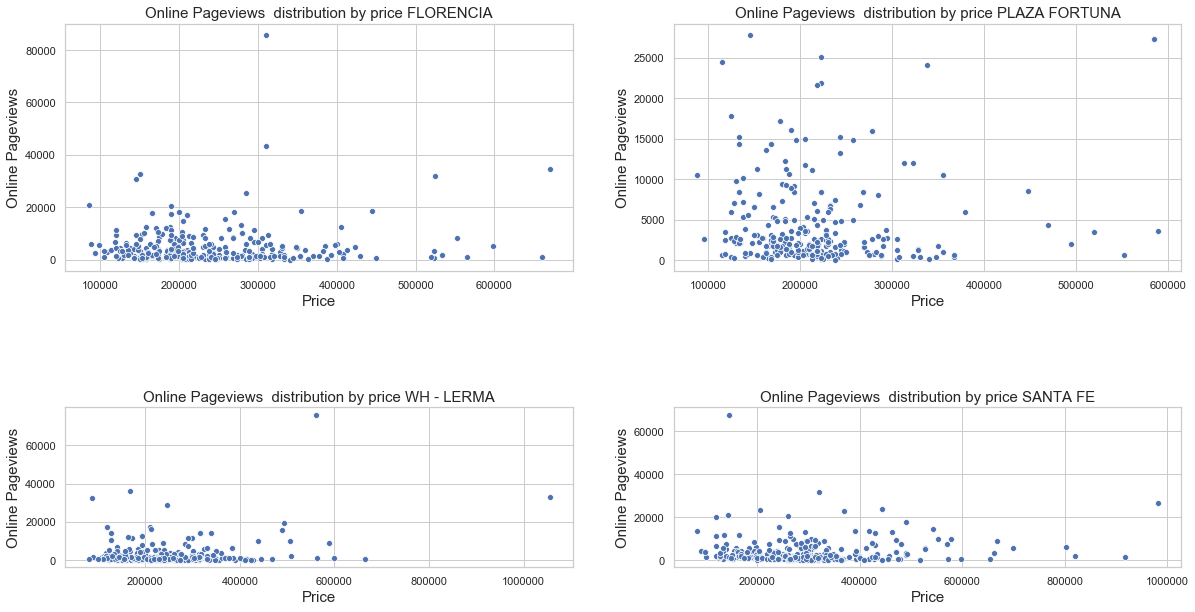

In [125]:
#####  Bar Graphs Brands per Showroom  #####

fig, axes = plt.subplots(figsize=(20,10))
plt.subplot(2,2,1)
SS3=car_description[car_description['location_name']=='Florencia']
order = SS3.groupby('published_price')['tot_pageviews'].mean().sort_values(ascending=True).iloc[::1].index
m = sns.scatterplot(x="published_price",y="tot_pageviews", data=SS3)
m.set_title('Online Pageviews  distribution by price FLORENCIA', fontsize = 15)
m.set_ylabel('Online Pageviews', fontsize = 15)
m.set_xlabel('Price', fontsize = 15)

plt.subplot(2,2,2)
SS4=car_description[car_description['location_name']=='Fortuna']
order = SS4.groupby('published_price')['tot_pageviews'].mean().sort_values(ascending=True).iloc[::1].index
n = sns.scatterplot(x="published_price",y="tot_pageviews", data=SS4)
n.set_title('Online Pageviews  distribution by price PLAZA FORTUNA', fontsize = 15)
n.set_ylabel('Online Pageviews', fontsize = 15)
n.set_xlabel('Price', fontsize = 15)

plt.subplot(3,2,5)
SS5=car_description[car_description['location_name']=='Lerma 2']
order = SS5.groupby('published_price')['tot_pageviews'].mean().sort_values(ascending=True).iloc[::1].index
o = sns.scatterplot(x="published_price",y="tot_pageviews", data=SS5)
o.set_title('Online Pageviews  distribution by price WH - LERMA', fontsize = 15)
o.set_ylabel('Online Pageviews', fontsize = 15)
o.set_xlabel('Price', fontsize = 15)

plt.subplot(3,2,6)
SS6=car_description[car_description['location_name']=='Patio Sta Fe']
order = SS6.groupby('published_price')['tot_pageviews'].mean().sort_values(ascending=True).iloc[::1].index
p = sns.scatterplot(x="published_price",y="tot_pageviews", data=SS6)
p.set_title('Online Pageviews  distribution by price SANTA FE', fontsize = 15)
p.set_ylabel('Online Pageviews', fontsize = 15)
p.set_xlabel('Price', fontsize = 15);

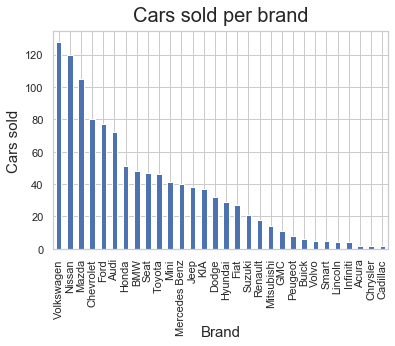

In [101]:
car_description['brand_name'].value_counts().plot.bar()
plt.title("Cars sold per brand", fontsize=20, verticalalignment='bottom');
plt.ylabel("Cars sold", fontsize=15, verticalalignment='bottom');
plt.xlabel('Brand', fontsize=15, verticalalignment='bottom');



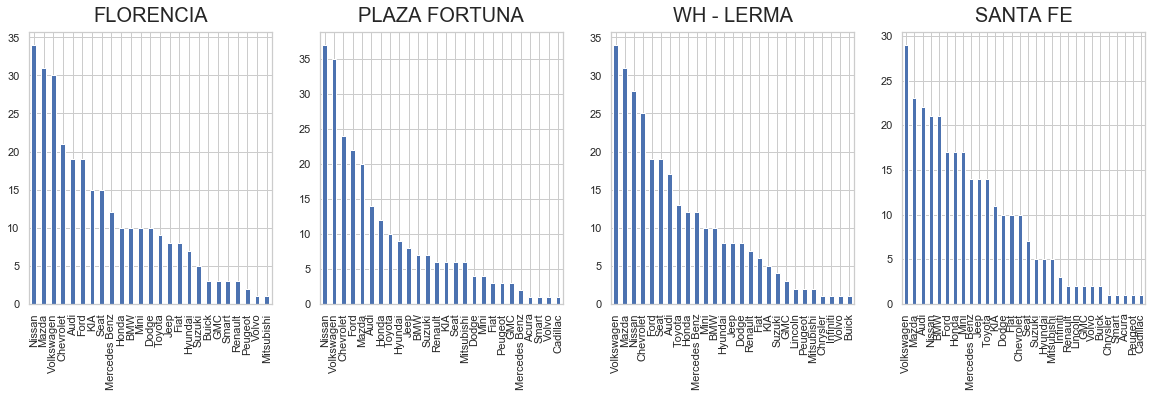

In [115]:
#####  Bar Graphs Brands per Showroom  #####

fig, axes = plt.subplots(figsize=(20,5))
plt.subplot(1,4,1)
SS3=car_description[car_description['location_name']=='Florencia']
SS3['brand_name'].value_counts().plot.bar()
plt.title("FLORENCIA", fontsize=20, verticalalignment='bottom')

plt.subplot(1,4,2)
SS4=car_description[car_description['location_name']=='Fortuna']
SS4['brand_name'].value_counts().plot.bar()
plt.title("PLAZA FORTUNA", fontsize=20, verticalalignment='bottom')

plt.subplot(1,4,3)
SS5=car_description[car_description['location_name']=='Lerma 2']
SS5['brand_name'].value_counts().plot.bar()
plt.title("WH - LERMA", fontsize=20, verticalalignment='bottom')

plt.subplot(1,4,4)
SS6=car_description[car_description['location_name']=='Patio Sta Fe']
SS6['brand_name'].value_counts().plot.bar()
plt.title("SANTA FE", fontsize=20, verticalalignment='bottom');

In [104]:
car_description.columns

Index(['car_description_id', 'item', 'location_id', 'sold_location_id',
       'stock_id', 'internal_id', 'brand_id', 'year', 'km', 'sku', 'color',
       'sold_date', 'version', 'accepted_offer_type', 'buy_price',
       'published_price', 'price_segment', 'km_segment', 'model_segment',
       'maker_segment', 'delivered_date', 'inventory_days', 'location_name',
       'brand_name', 'new_price_segment', 'new_km_segment',
       'new_model_segment', 'sold_datetime', 'month', 'my', 'tot_pageviews',
       'wopv'],
      dtype='object')

Text(0.5, 0, 'brand')

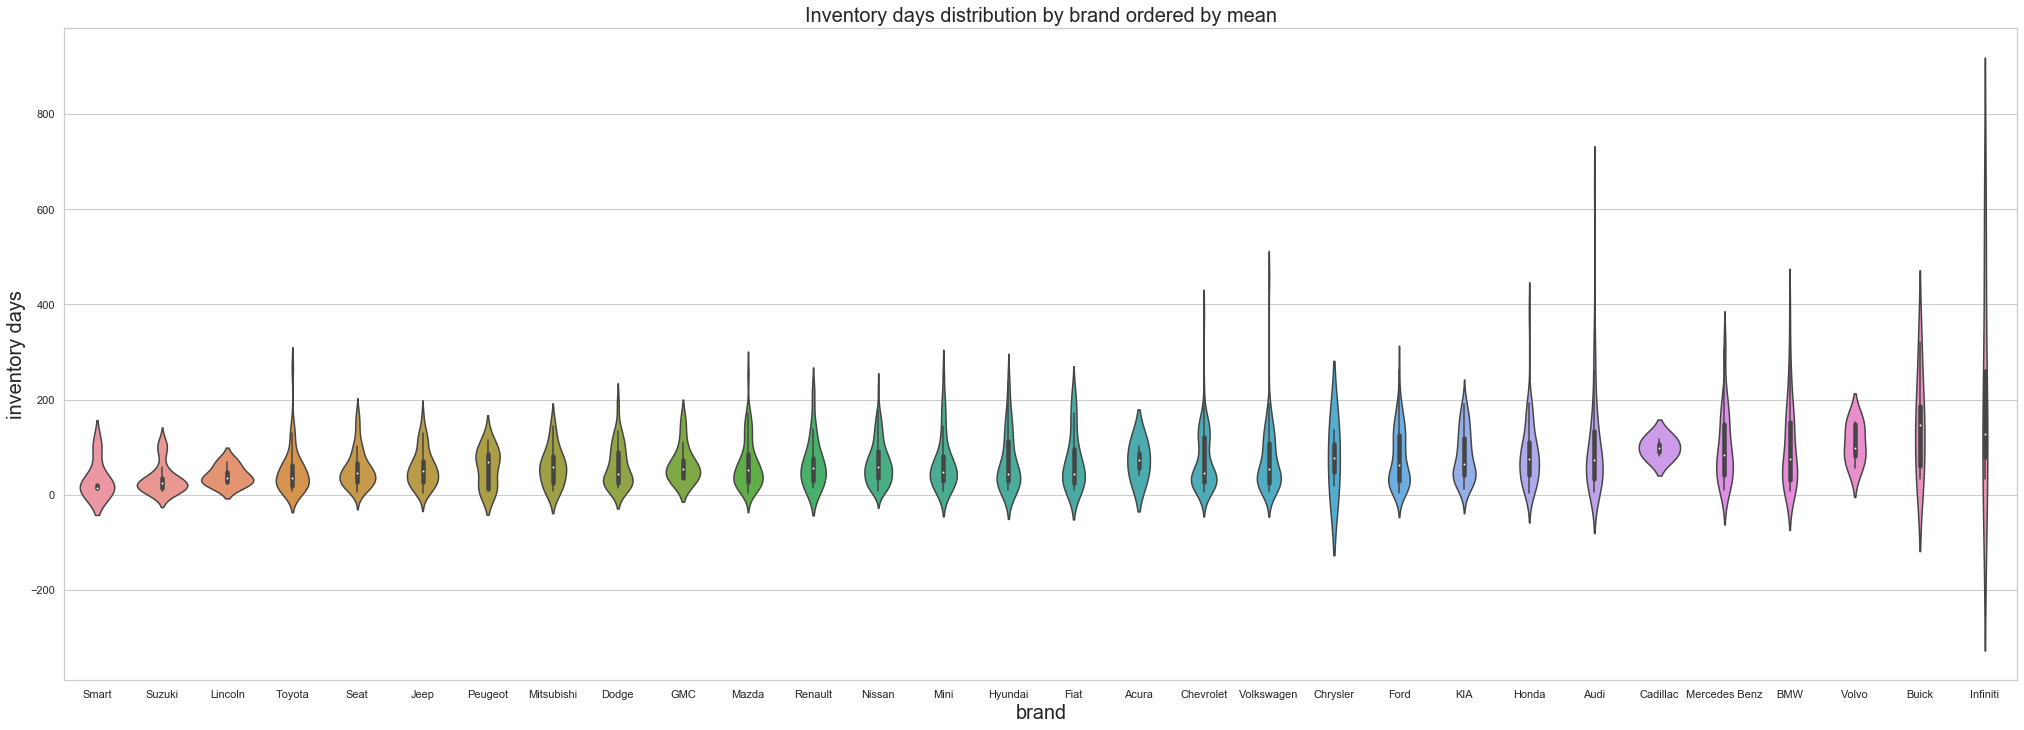

In [107]:
order = car_description.groupby('brand_name')['inventory_days'].mean().sort_values(ascending=True).iloc[::1].index
fig, ax = plt.subplots(figsize=(35,12))
m = sns.violinplot(x="brand_name",y="inventory_days",data=car_description,orient='vertical', order = order , fontsize = 30)
m.set_title('Inventory days distribution by brand ordered by mean', fontsize = 20)
m.set_ylabel('inventory days', fontsize = 20)
m.set_xlabel('brand', fontsize = 20)

Text(0.5, 0, 'brand')

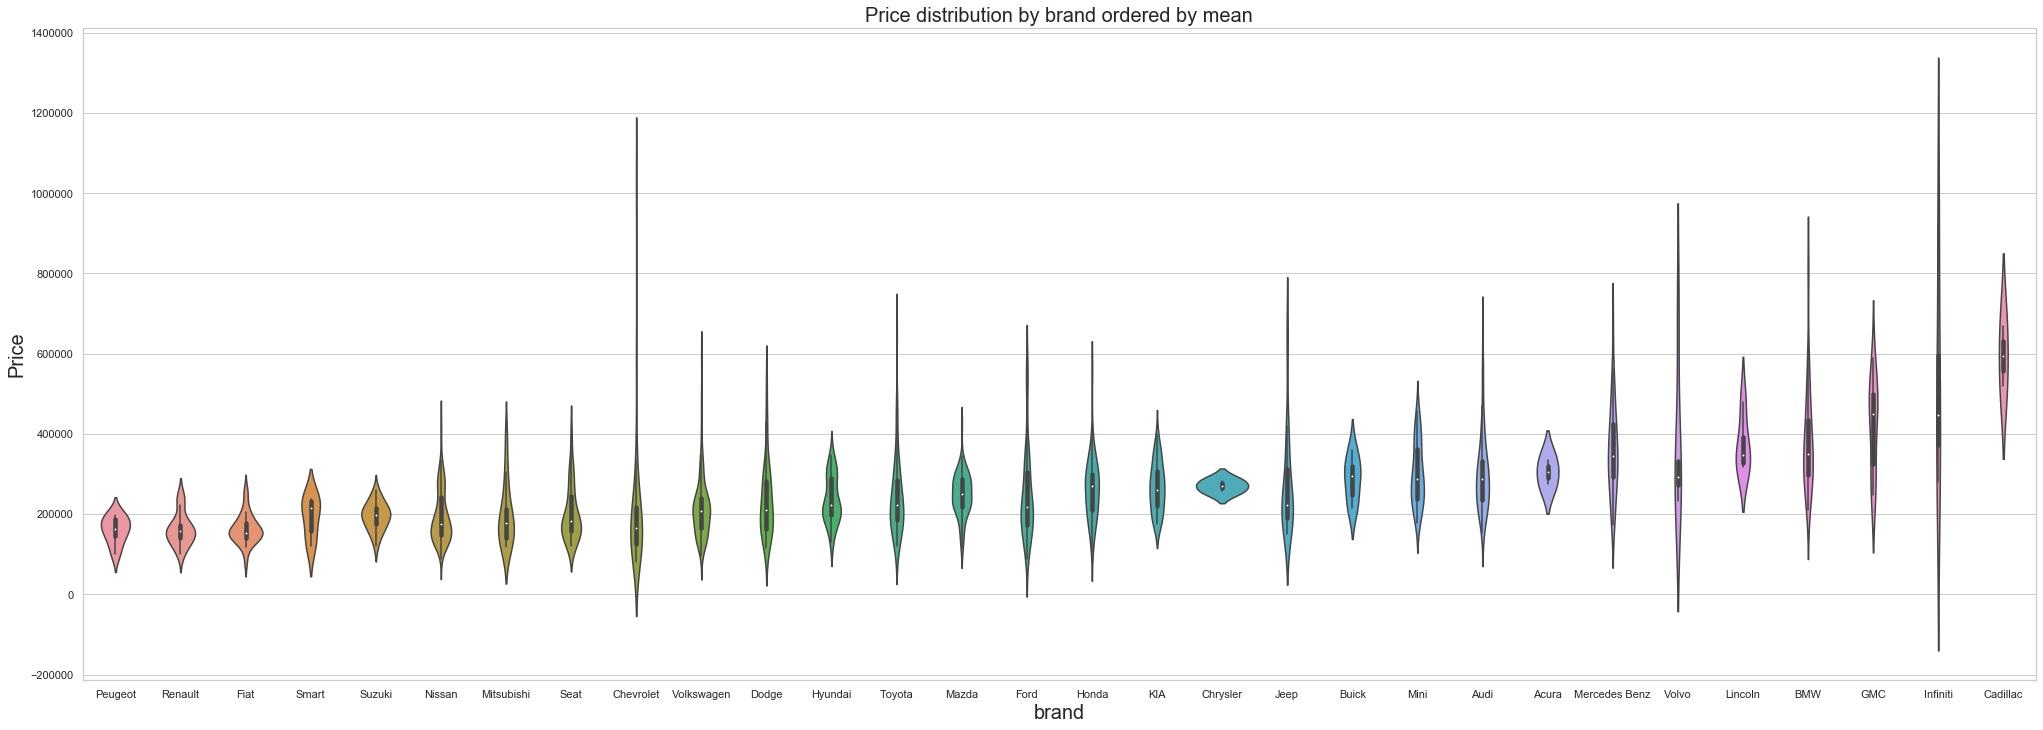

In [108]:
order = car_description.groupby('brand_name')['published_price'].mean().sort_values(ascending=True).iloc[::1].index
fig, ax = plt.subplots(figsize=(35,12))
m = sns.violinplot(x="brand_name",y="published_price",data=car_description,orient='vertical', order = order , fontsize = 30)
m.set_title('Price distribution by brand ordered by mean', fontsize = 20)
m.set_ylabel('Price', fontsize = 20)
m.set_xlabel('brand', fontsize = 20)

Text(0.5, 0, 'brand')

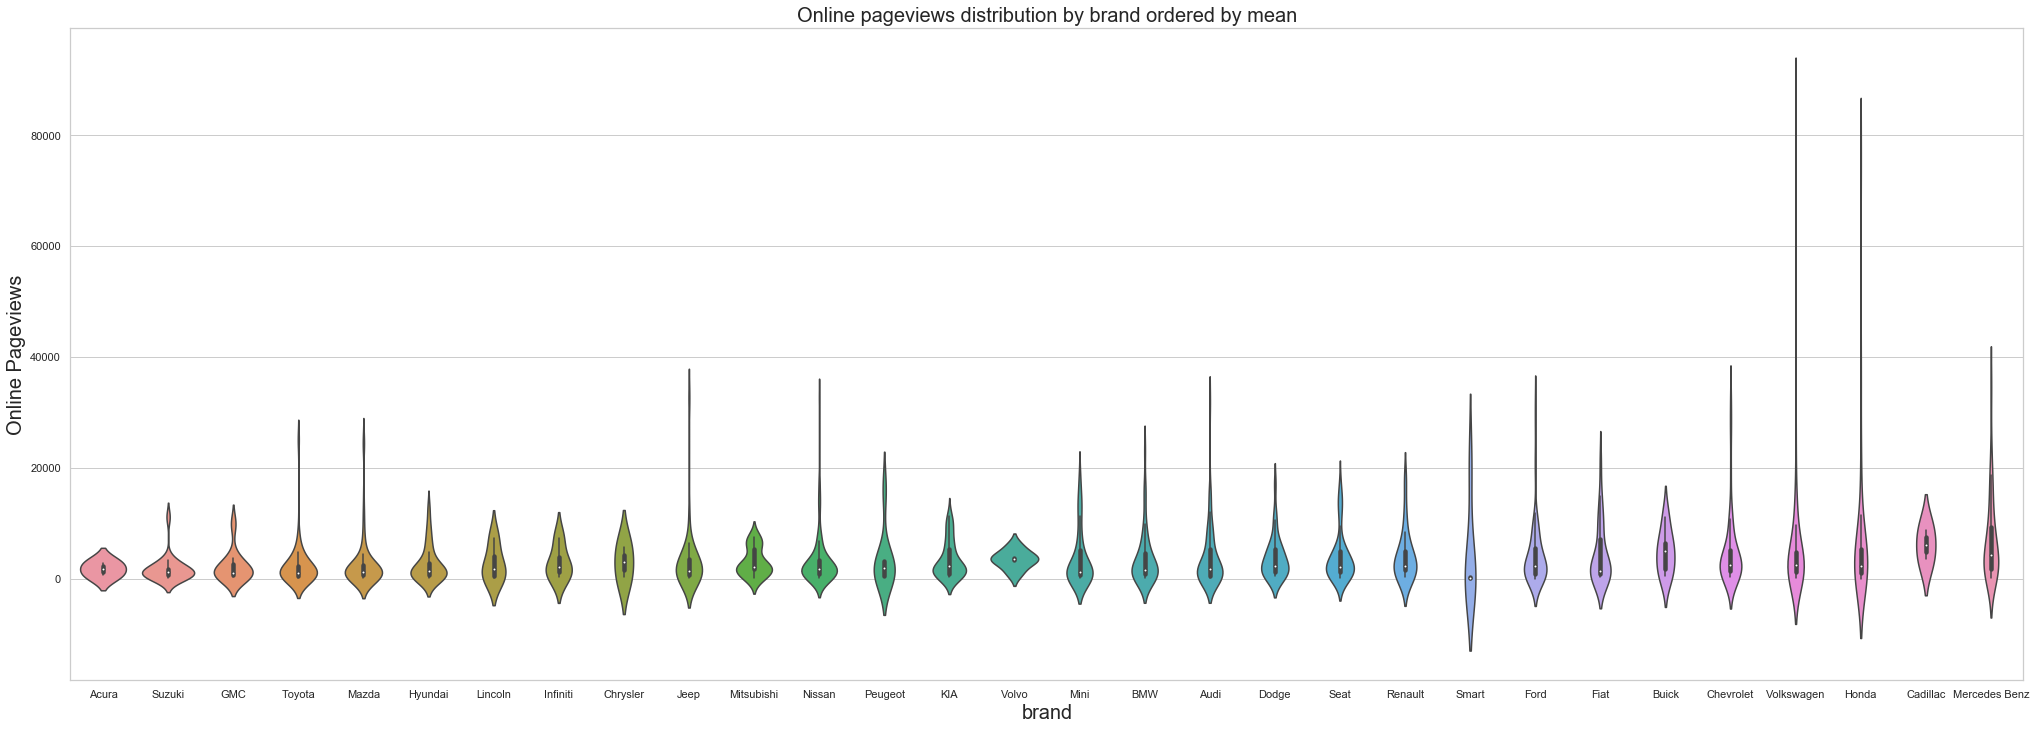

In [65]:
order = car_description.groupby('brand_name')['tot_pageviews'].mean().sort_values(ascending=True).iloc[::1].index
fig, ax = plt.subplots(figsize=(35,12))
m = sns.violinplot(x="brand_name",y="tot_pageviews",data=car_description,orient='vertical', order = order , fontsize = 30)
m.set_title('Online pageviews distribution by brand ordered by mean', fontsize = 20)
m.set_ylabel('Online Pageviews', fontsize = 20)
m.set_xlabel('brand', fontsize = 20)